In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


SyntaxError: invalid syntax (vis.py, line 34)

In [2]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [3]:
def adaptive(M, nu, j, Ma_T, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    err_indicator=[]
    refined=[]
    P = []
    #params['u_sol']=u_sol
    # params['ux']=ux
    # params['uy']=uy
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            fig = plt.figure()
            MP.mesh.draw(fig, knots=False)
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:0})
        #print(bcs)

        # assemble the linear system
        Kh = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('j * v + inner(Ma_T, grad(v)) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in ['M1','M2']],axis=0)

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A))(LS.b))
        #u_ = (cholesky(Mh))(u_rhs)
        #print(check_coupling(MP,u_))
        
        #eh=uh-u_
        #L2err[iter] = sqrt(eh.T@Mh@eh)
        #H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_indicator.append(adap.PoissonEstimator(MP,uh,f=j,a=nu, M=Ma_T, physical=True))
            err_est[iter] = norm(err_indicator[-1])
            marked_patches = adap.doerfler_marking(err_indicator[-1], theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            P_i = MP.patch_refine(h_ref=marked_patches, return_P = True)
            for i in range(len(P)):
                P[i]=P_i@P[i]
            P.append(P_i)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            # start=time.time()
            # MP = assemble.Multipatch(M, automatch = True)
            # end = time.time()
            print("Basis setup took " + str(end-start) + " seconds.")
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, err_indicator, refined, P

In [4]:
def Motor(deg,N,full=False):
    # X=(bspline.make_knots(deg,0.0,1.0,3*N),)+3*(bspline.make_knots(deg,0.0,1.0,N),)+(bspline.make_knots(deg,0.0,1.0,2*N),)
    # Y=2*(bspline.make_knots(deg,0.0,1.0,N),)+(bspline.make_knots(deg,0.0,1.0,3*N),)+3*(bspline.make_knots(deg,0.0,1.0,N),)+(bspline.make_knots(deg,0.0,1.0,3*N),)+2*(bspline.make_knots(deg,0.0,1.0,N),)
    # kvs=list(itertools.product(X,Y))
    # kvs=[(kv1,kv0) for kv0, kv1 in kvs]
    kvs = 45*[2 * (bspline.make_knots(deg, 0.0, 1.0, N),),]
    a,b,c,d,e,f=.3,1.,1.1,1.15,1.16,1.5
    th_m,th_air,th_fe=31.,2.,5. # 2*th_m + 4*th_air + 2*th_fe = 90!!!
    geos=[
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_fe/360),
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=a,r2=b,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360),    
        
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_fe/360),
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=b,r2=c,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360), 
        
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_fe/360),
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=c,r2=d,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360), 
        
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_fe/360),
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=d,r2=e,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360), 
        
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_fe/360),
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=e,r2=f,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360),
    ]

    Fe = {0,1,2,3,4,5,6,7,8,9,13,17,18,19,20,21,22,23,24,25,26,36,37,38,39,40,41,42,43,44}
    Air={10,12,14,16,27,28,29,30,31,32,33,34,35}
    M1={11}
    M2={15}

    if full:
        kvs=4*kvs
        Fe = set().union(*[{x + 45*i for x in Fe} for i in range(4)])
        Air = set().union(*[{x + 45*i for x in Air} for i in range(4)])
        M1 = set().union(*[{x + 45*i for x in M1} for i in range(4)])
        M2 = set().union(*[{x + 45*i for x in M2} for i in range(4)])
        geos = [g for g in geos] + [g.rotate_2d(pi/2) for g in geos] + [g.rotate_2d(pi) for g in geos] + [g.rotate_2d(3/2*pi) for g in geos]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
    #patches = [(k, g) for k, g in zip(kvs,geos)]

    t=time.time()
    M = topology.PatchMesh(patches, domains={'M1':M1,'M2':M2,'Fe':Fe,'Air':Air})
    print('Detecting interfaces took ' + str(time.time()-t) + ' seconds.')
    
    M.rename_boundary(0,'D')
    if not full:                            #periodic boundary conditions
        M.set_boundary_id({'N':{(0,0),(9,0),(18,0),(27,0),(36,0),(8,1),(17,1),(26,1),(35,1),(44,1)}})
        #M.add_interface(0 ,0,0,8 ,1,0,(False,))
        #M.add_interface(9 ,0,0,17,1,0,(False,))
        #M.add_interface(18,0,0,26,1,0,(False,))
        #M.add_interface(27,0,0,35,1,0,(False,))
        #M.add_interface(36,0,0,44,1,0,(False,))
    return M
#M.set_boundary_id({'D1':{(0,2),(8,2),(16,2),(24,2)}})
#M.set_boundary_id({'D2':{(7,3),(15,3),(23,3),(31,3)}})

In [5]:
rho=1.28

nu = {'M1': 1e7/(4.344*pi), 'M2':1e7/(4.344*pi), 'Fe':1e5/(204*pi), 'Air': 1e7/(4*pi)}
#nu = {'M1': 1., 'M2': 1., 'Fe': 1., 'Air': 1.}

Ma_T = {'M1': lambda x,y: tuple(rho*nu['M1']*np.array([-y,x])/sqrt(x**2+y**2)), 
        'M2':lambda x,y: tuple(rho*nu['M2']*np.array([y,-x])/sqrt(x**2+y**2)), 
        'Fe':lambda x,y: (0.,0.), 
        'Air': lambda x,y: (0.,0.)}

j = {'M1': lambda x,y: 0.0, 'M2':lambda x,y: 0.0, 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}

In [6]:
#M=Motor(deg,deg+1)

In [7]:
#M.draw(color={'M1':'yellow', 'M2':'yellow','Fe':'darkgrey','Air':'white'},bcolor={'D':'blue','N':'red'})

In [25]:
deg=2
M=Motor(deg,deg+1)
MP = assemble.Multipatch(M, automatch=True)
maxiter=[7,7,6]
uh=[]
numdofs = np.zeros(maxiter[deg-2],dtype=float)
P=[]
return_P = True

for i in range(maxiter[deg-2]):
    print(i)
    numdofs[i] = MP.numdofs
    print(MP.numdofs)
    bcs = MP.compute_dirichlet_bcs({'D':0.})
    t=time.time()
    Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP.assemble_volume('(j * v - inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
    Kh = MP.assemble_volume(vform.stiffness_vf(2))
    Mh = MP.assemble_volume(vform.mass_vf(2))
    LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
    print('assembly took '+str(time.time()-t)+' seconds.')
    t=time.time()
    uh.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
    print('solving took '+str(time.time()-t)+' seconds.')
    
    if i < maxiter[deg-2]-2 :
        P.append(MP.h_refine(h_ref=-1, return_P=return_P))
    elif i == maxiter[deg-2]-2:
        P.append(MP.p_refine(p_inc=1, return_P=return_P))
    else:
        pass
    MP.sanity_check()
    
for k in reversed(range(1,len(P))):
    P[k-1]=P[k]@P[k-1]
    
L2err = np.zeros(maxiter[deg-2])
H1err = np.zeros(maxiter[deg-2])
Aherr = np.zeros(maxiter[deg-2])
for i in range(len(uh)-1):
    eh = P[i]@uh[i]-uh[-1]
    L2err[i] = eh @ Mh @ eh
    H1err[i] = eh @ Kh @ eh + L2err[-1]
    Aherr[i] = eh @ Ah @ eh
    
L2err = sqrt(L2err)
H1err = sqrt(H1err)
Aherr = sqrt(Aherr)

np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt', np.c_[[numdofs,H1err,L2err,Aherr]])

Detecting interfaces took 2.6193253993988037 seconds.
Basis setup took 0.011316537857055664 seconds
0
777
assembly took 0.8339343070983887 seconds.
solving took 0.0014042854309082031 seconds.
Refinement took 0.0012810230255126953 seconds for 45 patches.
Basis setup took 0.013049840927124023 seconds
Prolongation took 0.07945775985717773 seconds
1
2304
assembly took 0.8851573467254639 seconds.
solving took 0.0036773681640625 seconds.
Refinement took 0.0013501644134521484 seconds for 45 patches.
Basis setup took 0.0175933837890625 seconds
Prolongation took 0.08428764343261719 seconds
2
7788
assembly took 1.0537490844726562 seconds.
solving took 0.014139890670776367 seconds.
Refinement took 0.0014662742614746094 seconds for 45 patches.
Basis setup took 0.0298006534576416 seconds
Prolongation took 0.0894002914428711 seconds
3
28476
assembly took 1.528031826019287 seconds.
solving took 0.06442070007324219 seconds.
Refinement took 0.0015141963958740234 seconds for 45 patches.
Basis setup took

In [11]:
deg=4
M_geo=Motor(deg,deg+1)
MP_geo = assemble.Multipatch(M_geo, automatch=True)
maxiter=[20,20,20]
uh_geo=[]
numdofs_geo = np.zeros(maxiter[deg-2],dtype=float)
P=[]
return_P = True

for i in range(maxiter[deg-2]):
    print(i)
    numdofs_geo[i] = MP_geo.numdofs
    print(MP_geo.numdofs)
    bcs = MP_geo.compute_dirichlet_bcs({'D':0.})
    t=time.time()
    Ah = sum([MP_geo.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP_geo.assemble_volume('(j * v - inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
    Kh = MP_geo.assemble_volume(vform.stiffness_vf(2))
    Mh = MP_geo.assemble_volume(vform.mass_vf(2))
    LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
    print('assembly took '+str(time.time()-t)+' seconds.')
    t=time.time()
    uh_geo.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
    print('solving took '+str(time.time()-t)+' seconds.')
    
    if i < maxiter[deg-2]-2 :
        P.append(MP_geo.h_refine(h_ref='q', return_P=return_P))
    elif i == maxiter[deg-2]-2:
        P.append(MP_geo.p_refine(p_inc=1, return_P=return_P))
    else:
        pass
    MP_geo.sanity_check()
    
for k in reversed(range(1,len(P))):
    P[k-1]=P[k]@P[k-1]
    
L2err_geo = np.zeros(maxiter[deg-2])
H1err_geo = np.zeros(maxiter[deg-2])
Aherr_geo = np.zeros(maxiter[deg-2])
for i in range(len(uh_geo)-1):
    eh = P[i]@uh_geo[i]-uh_geo[-1]
    L2err_geo[i] = eh @ Mh @ eh
    H1err_geo[i] = eh @ Kh @ eh + L2err_geo[-1]
    Aherr_geo[i] = eh @ Ah @ eh
    
L2err_geo = sqrt(L2err_geo)
H1err_geo = sqrt(H1err_geo)
Aherr_geo = sqrt(Aherr_geo)

np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'geo.txt', np.c_[[numdofs_geo,H1err_geo,L2err_geo,Aherr_geo]])

Detecting interfaces took 3.027827501296997 seconds.
Basis setup took 0.014186859130859375 seconds
0
2993
assembly took 1.083564281463623 seconds.
solving took 0.008092164993286133 seconds.
Refinement took 0.0017709732055664062 seconds for 45 patches.
Basis setup took 0.015932321548461914 seconds
Prolongation took 0.08269429206848145 seconds
1
4641
assembly took 1.2004718780517578 seconds.
solving took 0.013962268829345703 seconds.
Refinement took 0.0018224716186523438 seconds for 45 patches.
Basis setup took 0.017093181610107422 seconds
Prolongation took 0.08482503890991211 seconds
2
6649
assembly took 1.3622043132781982 seconds.
solving took 0.02328205108642578 seconds.
Refinement took 0.0017702579498291016 seconds for 45 patches.
Basis setup took 0.020420551300048828 seconds
Prolongation took 0.09426069259643555 seconds
3
9017
assembly took 1.5619258880615234 seconds.
solving took 0.03382730484008789 seconds.
Refinement took 0.00179290771484375 seconds for 45 patches.
Basis setup to

Detecting interfaces took 2.713428020477295 seconds.
Basis setup took 0.012062549591064453 seconds


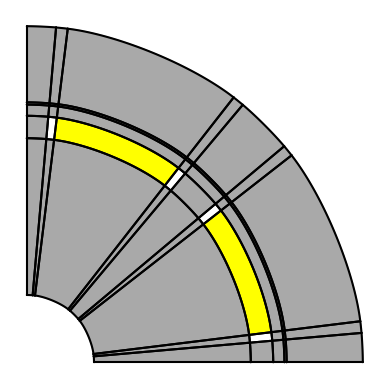

0
Residual contributions took 0.39482975006103516 seconds.
Jump contributions took 0.6242003440856934 seconds.
0.0053997039794921875
0.00563812255859375
Refinement took 0.011072635650634766 seconds for 2 patches.
Basis setup took 0.015008687973022461 seconds
Prolongation took 0.015297174453735352 seconds


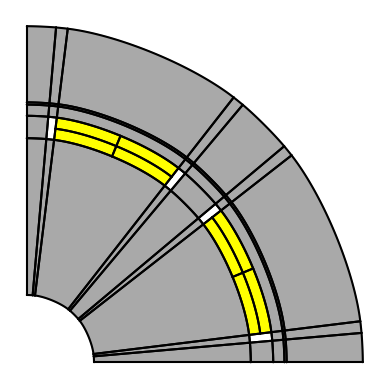

1
Residual contributions took 0.4313080310821533 seconds.
Jump contributions took 0.7679061889648438 seconds.
0.0058650970458984375
0.006009340286254883
0.006195783615112305
0.006395101547241211
0.006667137145996094
0.006949424743652344
0.0071523189544677734
0.007332324981689453
0.007519960403442383
Refinement took 0.06022000312805176 seconds for 9 patches.
Basis setup took 0.023032426834106445 seconds
Prolongation took 0.06602072715759277 seconds


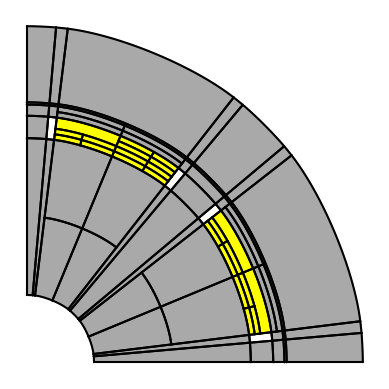

2
Residual contributions took 0.6586840152740479 seconds.
Jump contributions took 1.335524320602417 seconds.
0.007704734802246094
0.007905721664428711
0.007987737655639648
0.00829625129699707
0.00835728645324707
0.008705854415893555
0.008865118026733398
0.009060859680175781
0.009277582168579102
0.009386777877807617
0.009630918502807617
0.009916067123413086
0.010176658630371094
0.010330438613891602
0.010464191436767578
Refinement took 0.1362900733947754 seconds for 15 patches.
Basis setup took 0.03943490982055664 seconds
Prolongation took 0.1098933219909668 seconds


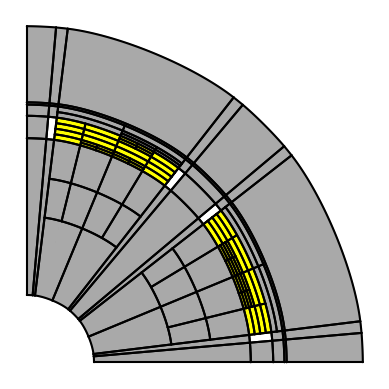

3
Residual contributions took 1.0370736122131348 seconds.
Jump contributions took 2.255075216293335 seconds.
0.01062917709350586
0.010813236236572266
0.011050701141357422
0.011126995086669922
0.011353731155395508
0.011700868606567383
0.011808156967163086
Refinement took 0.07859158515930176 seconds for 7 patches.
Basis setup took 0.045374155044555664 seconds
Prolongation took 0.052133798599243164 seconds


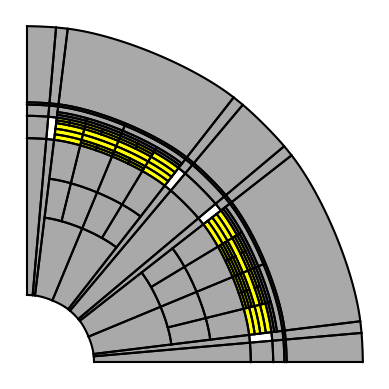

4
Residual contributions took 1.2147696018218994 seconds.
Jump contributions took 2.6901750564575195 seconds.
0.011965751647949219
0.012164592742919922
0.012367963790893555
0.012474298477172852
0.012593984603881836
0.012813091278076172
0.013013601303100586
0.013440370559692383
0.013519048690795898
0.013588428497314453
0.013814449310302734
0.01392507553100586
0.014166593551635742
0.014288902282714844
0.01434469223022461
0.015439033508300781
0.01508188247680664
0.015112876892089844
0.015114307403564453
0.01539158821105957
0.015571117401123047
0.01566004753112793
0.01597905158996582
0.016055583953857422
0.016295433044433594
0.016525745391845703
0.016805410385131836
0.017017602920532227
0.018169641494750977
0.017976045608520508
0.017633438110351562
0.0178987979888916
0.018064022064208984
0.018111467361450195
0.018334150314331055
0.01854991912841797
0.018632173538208008
0.018862485885620117
0.019258737564086914
0.020577430725097656
0.01991581916809082
0.019807815551757812
0.0199775695800781

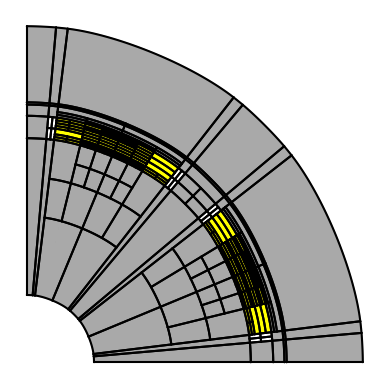

5
Residual contributions took 2.550002336502075 seconds.
Jump contributions took 5.862819194793701 seconds.
0.021969318389892578
0.02210235595703125
0.02218794822692871
0.02239990234375
0.023241281509399414
0.02393031120300293
0.02310633659362793
0.023189783096313477
0.024298906326293945
0.024020910263061523
0.02381110191345215
0.023885250091552734
0.02413463592529297
0.024255037307739258
0.024294614791870117
0.024514198303222656
0.024930715560913086
0.04778313636779785
0.025730133056640625
0.025508880615234375
0.02581334114074707
0.025851726531982422
0.0261685848236084
0.026224851608276367
0.02651500701904297
0.03748297691345215
0.040575265884399414
0.02790355682373047
0.027637958526611328
0.027753591537475586
0.02768993377685547
0.02779388427734375
0.028168439865112305
0.028148174285888672
0.029346704483032227
0.029053211212158203
0.028962135314941406
0.028894424438476562
0.028912067413330078
0.029093265533447266
0.029367685317993164
0.030287981033325195
0.030498504638671875
0.029918

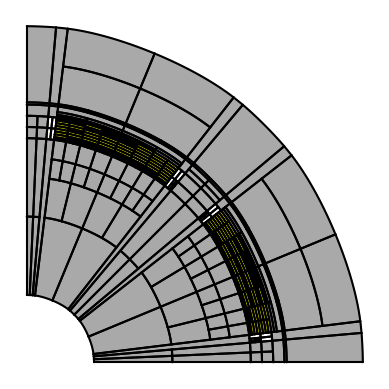

6
Residual contributions took 3.7987563610076904 seconds.
Jump contributions took 8.77186107635498 seconds.
0.03132748603820801
0.03123760223388672
0.03129434585571289
0.03163623809814453
0.03180074691772461
0.03214573860168457
0.06052827835083008
0.03314495086669922
0.03493475914001465
0.035170793533325195
0.03568100929260254
0.03513169288635254
0.038486480712890625
0.034212350845336914
0.03601980209350586
0.03410816192626953
0.034714698791503906
0.034320831298828125
0.03543210029602051
0.035321950912475586
0.034897565841674805
0.03479743003845215
0.03512239456176758
0.03500676155090332
0.03711056709289551
0.0362856388092041
0.03588438034057617
0.03614044189453125
0.03633689880371094
0.036672353744506836
0.03776073455810547
0.03720808029174805
0.03693866729736328
0.03696179389953613
0.03723263740539551
0.03736519813537598
0.03898763656616211
0.03837275505065918
0.03804659843444824
0.0384516716003418
0.03848528861999512
0.038520097732543945
0.04274415969848633
0.038604021072387695
0.03

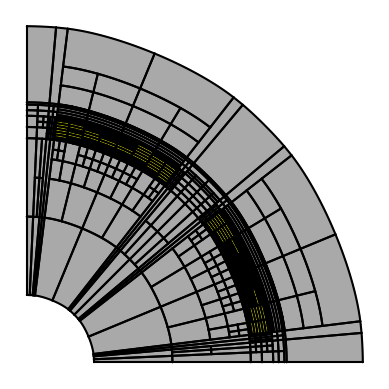

7
Residual contributions took 7.029712677001953 seconds.
Jump contributions took 16.11007595062256 seconds.
0.054082632064819336
0.05381441116333008
0.05415201187133789
0.05526375770568848
0.05472159385681152
0.054555654525756836
0.05477786064147949
0.0556941032409668
0.05574345588684082
0.0552210807800293
0.05519270896911621
0.05716085433959961
0.05737876892089844
0.056511878967285156
0.056188106536865234
0.058310508728027344
0.057959556579589844
0.05726122856140137
0.05736064910888672
0.05873250961303711
0.058069467544555664
0.05742383003234863
0.05763101577758789
0.059324026107788086
0.05893397331237793
0.05873417854309082
0.05896615982055664
0.060030221939086914
0.059370994567871094
0.05934262275695801
0.05949759483337402
0.06107497215270996
0.05994129180908203
0.06013345718383789
0.06042051315307617
0.06167435646057129
0.060834407806396484
0.060990095138549805
0.060655832290649414
0.07062387466430664
0.061705589294433594
0.061686038970947266
0.062047481536865234
0.0643200874328613

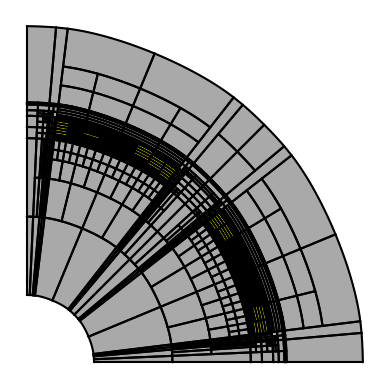

8
Residual contributions took 9.949511766433716 seconds.
Jump contributions took 23.035388469696045 seconds.
0.07498908042907715
0.07481884956359863
0.07587051391601562
0.07999038696289062
0.07630276679992676
0.07689332962036133
0.07697677612304688
0.07603120803833008
0.0801994800567627
0.0765678882598877
0.07645869255065918
0.0783379077911377
0.07755517959594727
0.07733750343322754
0.0786275863647461
0.07825899124145508
0.07818460464477539
0.08066534996032715
0.07980227470397949
0.0794837474822998
0.07976889610290527
0.07972168922424316
0.07952070236206055
0.07964038848876953
0.0796351432800293
0.08045005798339844
0.08145904541015625
0.08081269264221191
0.08064079284667969
0.08179759979248047
0.08243966102600098
0.0818793773651123
0.08243322372436523
0.08211660385131836
0.08223628997802734
0.08341121673583984
0.08293032646179199
0.08279633522033691
0.08428502082824707
0.0838775634765625
0.08394742012023926
0.08566069602966309
0.08536553382873535
0.08515453338623047
0.08581757545471191

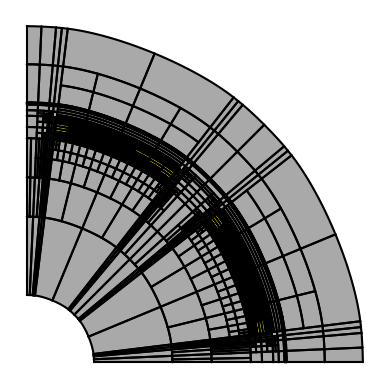

9
Residual contributions took 13.237107753753662 seconds.
Jump contributions took 30.705976009368896 seconds.
0.09830784797668457
0.09831833839416504
0.10067296028137207
0.10024213790893555
0.09987878799438477
0.10058975219726562
0.10088968276977539
0.10046839714050293
0.1010136604309082
0.10199880599975586
0.10315990447998047
0.10229802131652832
0.10743188858032227
0.10371208190917969
0.10298299789428711
0.10166501998901367
0.10694670677185059
0.10366368293762207
0.10381770133972168
0.10370540618896484
0.10408496856689453
0.10460567474365234
0.10578060150146484
0.10828232765197754
0.10594701766967773
0.10350775718688965
0.10524630546569824
0.10905599594116211
0.10604548454284668
0.10664939880371094
0.1098177433013916
0.10586786270141602
0.10653495788574219
0.10830187797546387
0.10653138160705566
0.10714054107666016
0.10794591903686523
0.10741353034973145
0.10761117935180664
0.10886812210083008
0.11376786231994629
0.10846662521362305
0.10895442962646484
0.10681962966918945
0.1069617271

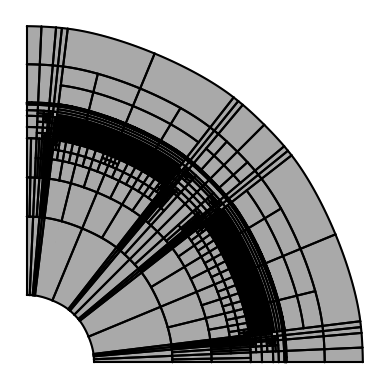

10
Residual contributions took 18.454760789871216 seconds.
Jump contributions took 42.75573754310608 seconds.
0.13523149490356445
0.13594484329223633
0.13519668579101562
0.13711333274841309
0.13608503341674805
0.13649964332580566
0.13654541969299316
0.14149951934814453
0.13832759857177734
0.13808917999267578
0.13781189918518066
0.13872981071472168
0.13824987411499023
0.1391921043395996
0.13974690437316895
0.1401805877685547
0.14101409912109375
0.14408516883850098
0.14133024215698242
0.14037680625915527
0.1398320198059082
0.14304113388061523
0.1405792236328125
0.1415419578552246
0.14108920097351074
0.14310216903686523
0.14118385314941406
0.14254975318908691
0.14076781272888184
0.14393091201782227
0.14239287376403809
0.1421799659729004
0.14728546142578125
0.14358019828796387
0.1423192024230957
0.14393115043640137
0.14347243309020996
0.1436009407043457
0.14269328117370605
0.1443617343902588
0.14468169212341309
0.14183902740478516
0.1438283920288086
0.14428019523620605
0.1442105770111084
0

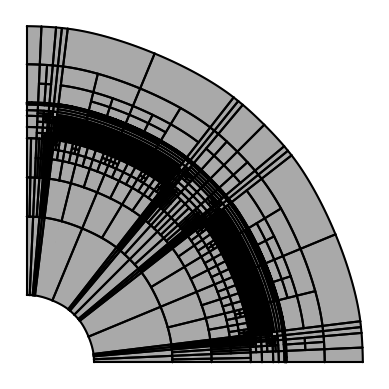

11
Residual contributions took 27.477434396743774 seconds.
Jump contributions took 63.6644229888916 seconds.
0.2012159824371338
0.20134973526000977
0.20362353324890137
0.20344972610473633
0.20247101783752441
0.2100667953491211
0.20740127563476562
0.20667719841003418
0.20373773574829102
0.2035207748413086
0.20441341400146484
0.20411396026611328
0.20829415321350098
0.20241332054138184
0.20298528671264648
0.20507073402404785
0.20618343353271484
0.2064359188079834
0.2052161693572998
0.2055823802947998
0.2073812484741211
0.2070457935333252
0.20755863189697266
0.20886707305908203
0.20997142791748047
0.20789432525634766
0.20648980140686035
0.20784211158752441
0.20353269577026367
0.20826220512390137
0.20951342582702637
0.20836663246154785
0.20771360397338867
0.20609760284423828
0.20812106132507324
0.20804834365844727
0.20961284637451172
0.21222352981567383
0.20677423477172852
0.2095940113067627
0.20686745643615723
0.21414661407470703
0.21053838729858398
0.21196794509887695
0.21216678619384766


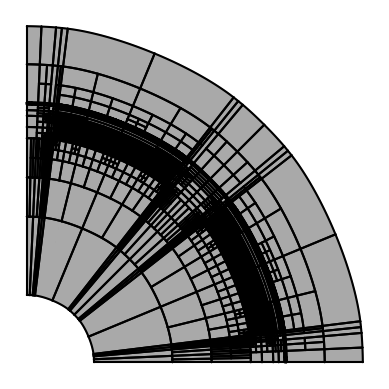

12
Residual contributions took 35.83291530609131 seconds.
Jump contributions took 84.86469030380249 seconds.
0.27662062644958496
0.26195192337036133
0.2679605484008789
0.263577938079834
0.2680649757385254
0.2721576690673828
0.26373815536499023
0.33265113830566406
0.2651042938232422
0.2662925720214844
0.2666780948638916
0.2664649486541748
0.2679712772369385
0.26422739028930664
0.31038331985473633
0.26424551010131836
0.2647559642791748
0.26705360412597656
0.2689781188964844
0.268784761428833
0.26694798469543457
0.2685360908508301
0.2663452625274658
0.26311182975769043
0.267289400100708
0.268416166305542
0.2676999568939209
0.2708902359008789
0.26700377464294434
0.2675447463989258
0.2697927951812744
0.2681419849395752
0.2682981491088867
0.2718362808227539
0.272113561630249
0.2701563835144043
0.2717761993408203
0.2695748805999756
0.26981568336486816
0.27064037322998047
0.27210092544555664
0.27243590354919434
0.27295470237731934
0.27288222312927246
0.2736680507659912
0.271028995513916
0.2709

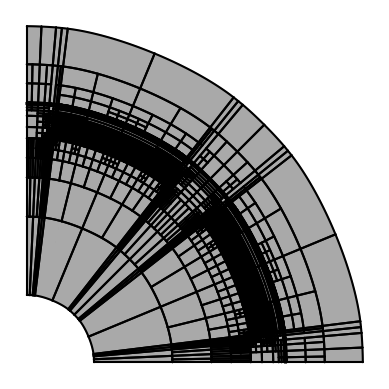

13
Residual contributions took 44.69253849983215 seconds.
Jump contributions took 104.72590565681458 seconds.
0.342693567276001
0.32930874824523926
0.3346736431121826
0.33049798011779785
0.33129143714904785
0.3283262252807617
0.32900214195251465
0.32849907875061035
0.33240818977355957
0.330308198928833
0.33480072021484375
0.35050344467163086
0.3287203311920166
0.33324551582336426
0.33220672607421875
0.32984399795532227
0.3303194046020508
0.3310239315032959
0.3323676586151123
0.33980560302734375
0.3354196548461914
0.3702399730682373
0.34700584411621094
0.3445277214050293
0.33996105194091797
0.3384685516357422
0.3498718738555908
0.3320944309234619
0.3332664966583252
0.3334681987762451
0.34010767936706543
0.33142518997192383
0.33292317390441895
0.3351142406463623
0.3332068920135498
0.342928409576416
0.3496880531311035
0.3475377559661865
0.33585548400878906
0.33882689476013184
0.3380444049835205
0.33759617805480957
0.33433103561401367
0.3337395191192627
0.3339512348175049
0.334228754043579

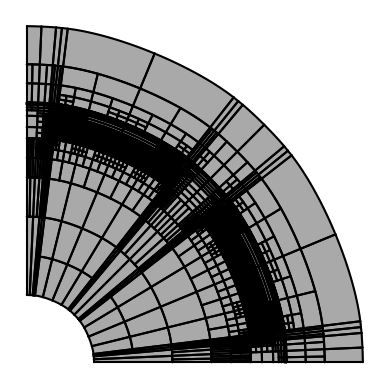

14
Basis setup took 10.644551992416382 seconds
Prolongation took 15.405006408691406 seconds


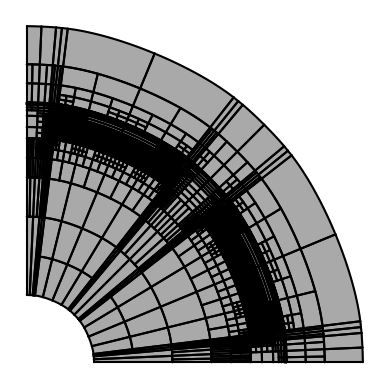

15


In [6]:
deg=2
maxiter=[16,17,20]
M_a=Motor(deg,deg+1,full=False)
MP_a = assemble.Multipatch(M_a, automatch=True)
uh_a=[]
P_a=[]
err_ind=[]


numdofs_a =np.zeros(maxiter[deg-2])
err_est=np.zeros(maxiter[deg-2])

for i in range(maxiter[deg-2]):
    MP_a.mesh.draw(color={'M1':'yellow', 'M2':'yellow','Fe':'darkgrey','Air':'white'},bwidth=0.01)
    plt.axis('off');
    plt.axis('scaled');
    plt.savefig('/home/wolfman/Pictures/Motor/p2/i'+str(i)+'.png',bbox_inches='tight');
    plt.show()
    print(i)
    bcs = MP_a.compute_dirichlet_bcs({'D':0.})
    Ah_a = sum([MP_a.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP_a.assemble_volume('(j * v - inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
    Kh_a = MP_a.assemble_volume(vform.stiffness_vf(2))
    Mh_a = MP_a.assemble_volume(vform.mass_vf(2))
    #print(Ah.shape)
    LS = assemble.RestrictedLinearSystem(Ah_a, F, bcs)
    uh_a.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
    numdofs_a[i] = MP_a.numdofs
    #print(MP_a.numdofs)
    
    if i < maxiter[deg-2]-2 :
        err_ind.append(adap.PoissonEstimator(MP_a,uh_a[-1],f=j,a=nu, M=Ma_T, neu_data={'N':0.}, physical=True))
        err_est[i] = norm(err_ind[-1])
        marked_patches = adap.doerfler_marking(err_ind[-1], 0.9)
        marked_patches = {p:None for p in marked_patches}
        P_a.append(MP_a.h_refine(h_ref=marked_patches, return_P=True))
        MP_a.mesh.sanity_check()
        MP_a.sanity_check()
        #MP_a.mesh.draw(plt.figure())
    elif i == maxiter[deg-2]-2:
        P_a.append(MP_a.p_refine(p_inc=1, return_P=True))
    else:
        pass
    
for k in reversed(range(1,len(P_a))):
    P_a[k-1]=P_a[k]@P_a[k-1]
    
L2err_a = np.zeros(maxiter[deg-2])
H1err_a = np.zeros(maxiter[deg-2])
Aherr_a = np.zeros(maxiter[deg-2])
for i in range(len(uh_a)-1):
    eh = P_a[i]@uh_a[i]-uh_a[-1]
    L2err_a[i] = eh @ Mh_a @ eh
    H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
    Aherr_a[i] = eh @ Ah_a @ eh
    
L2err_a = sqrt(L2err_a)
H1err_a = sqrt(H1err_a)
Aherr_a = sqrt(Aherr_a)

np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,Aherr_a]])

In [13]:
MP_a.numdofs

592749

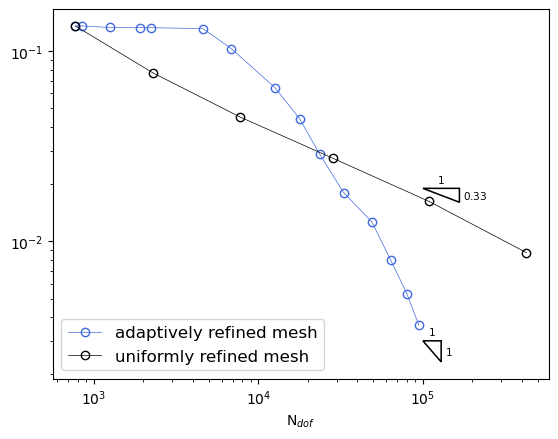

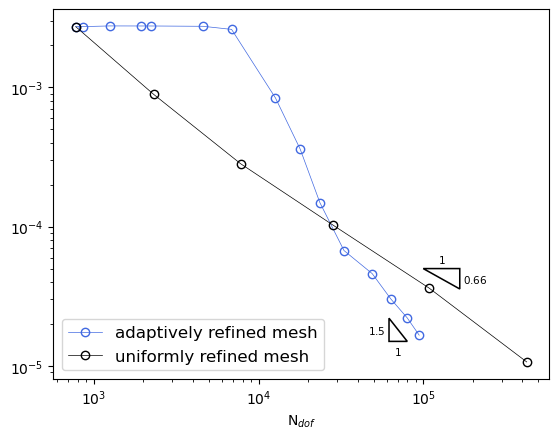

In [8]:
deg=2
[numdofs,H1err,L2err,err_est]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a,H1err_a,L2err_a,Aherr_a]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt')
[numdofs_geo,H1err_geo,L2err_geo,Aherr_geo]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'geo.txt')
fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_geo[:-1], H1err_geo[:-1], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(1e5,1.9*1e-2),1,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,3*1e-3),0.5,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'H1_cnv_corner.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_geo[:-1], L2err_geo[:-1], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(1e5,5*1e-5),1,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(8*1e4,1.5*1e-5),0.5,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv_corner.pdf', bbox_inches='tight')
plt.show()

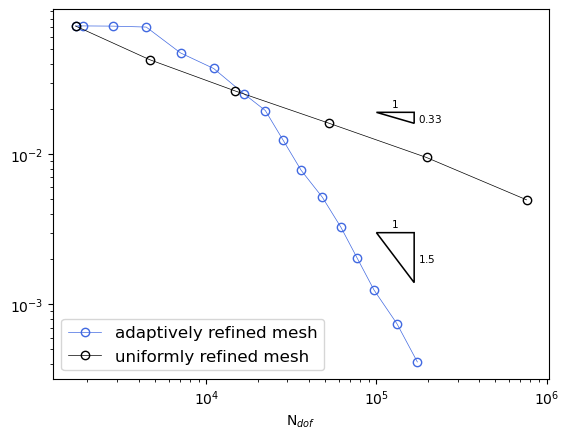

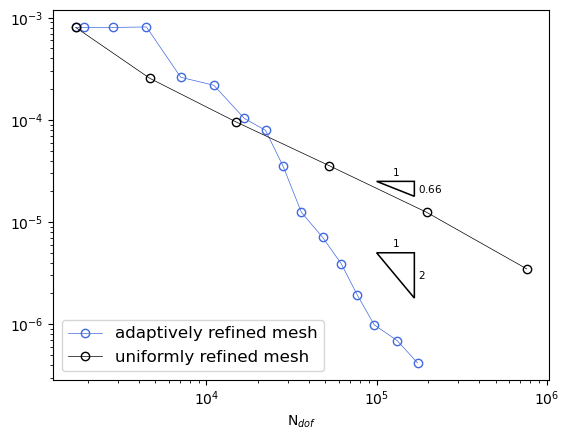

In [44]:
deg=3
[numdofs,H1err,L2err,err_est]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a,H1err_a,L2err_a,Aherr_a]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt')
fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(1e5,1.9*1e-2),1,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,3*1e-3),1,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'H1_cnv_corner.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(1e5,2.5*1e-5),1,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,5*1e-6),1,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv_corner.pdf', bbox_inches='tight')
plt.show()

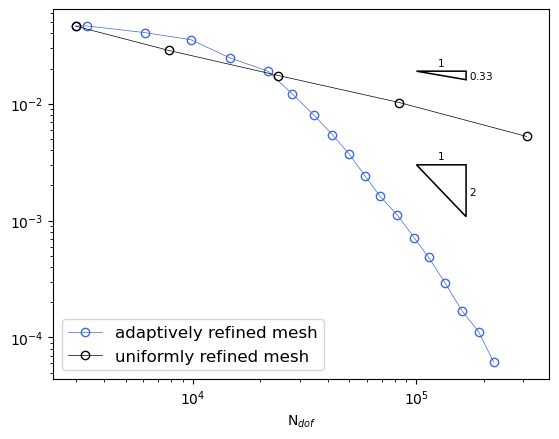

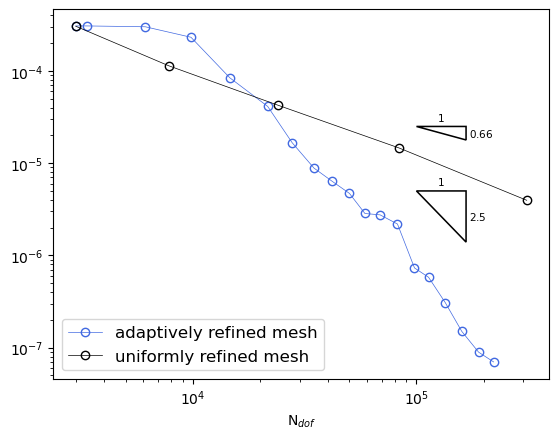

In [45]:
deg=4
[numdofs,H1err,L2err,err_est]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a,H1err_a,L2err_a,Aherr_a]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt')
fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(1e5,1.9*1e-2),1,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,3*1e-3),1,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'H1_cnv_corner.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')

plt.legend(['adaptively refined mesh','uniformly refined mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(1e5,2.5*1e-5),1,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,5*1e-6),1,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#plt.savefig('/home/wolfman/Pictures/Lshape_p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2_cnv_corner.pdf', bbox_inches='tight')
plt.show()

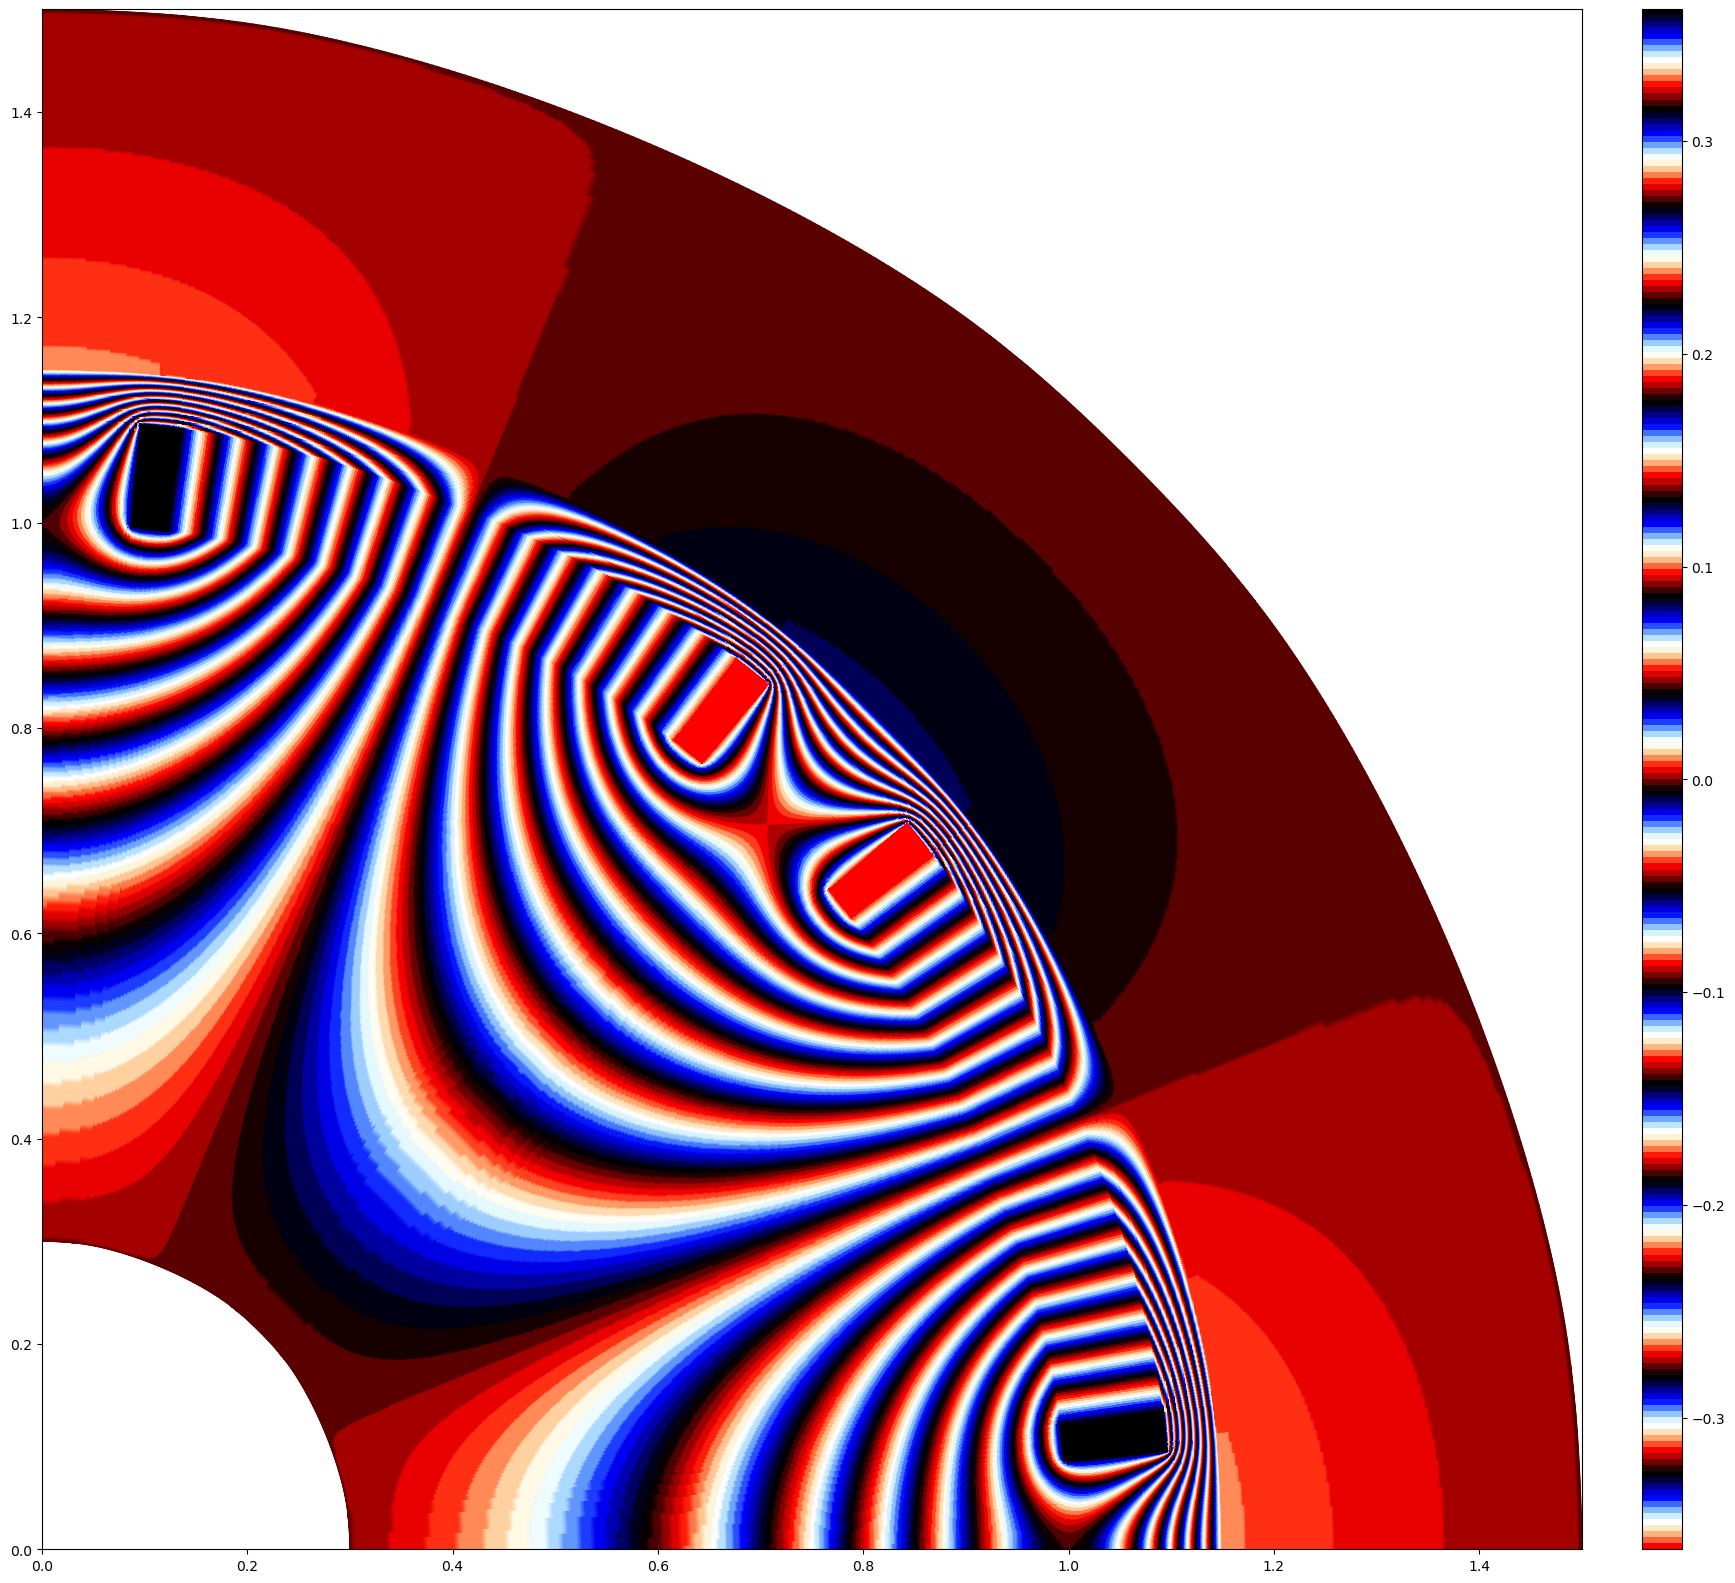

In [28]:
MP_a.plot(uh_a[-1], cmap='flag', figsize=(20,20))

In [25]:
P_a[0]

<758602x3450 sparse matrix of type '<class 'numpy.float64'>'
	with 6401166 stored elements in Compressed Sparse Row format>

In [7]:
err=adap.PoissonEstimator(MP,uh,f=j,a=nu, M=Ma_T, physical=True)

residual contributions took 1.468482255935669 seconds.
jump contributions took 2.404148817062378 seconds.


In [8]:
marked=adap.doerfler_marking(err,theta=0.8)

In [20]:
Ma_T['M1'](1,1)

(-663216.4391580891, 663216.4391580891)

In [18]:
deg=2
M=Motor(deg,deg+1,full=False)
MP=assemble.Multipatch(M, automatch=True)
bcs = MP.compute_dirichlet_bcs({0:0.})
Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
F = sum([MP.assemble_volume('(j * v - inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))

Detecting interfaces took 2.6801695823669434 seconds.
Basis setup took 0.013472318649291992 seconds


In [40]:
M=Motor(4,5)

Detecting interfaces took 2.7163403034210205 seconds.


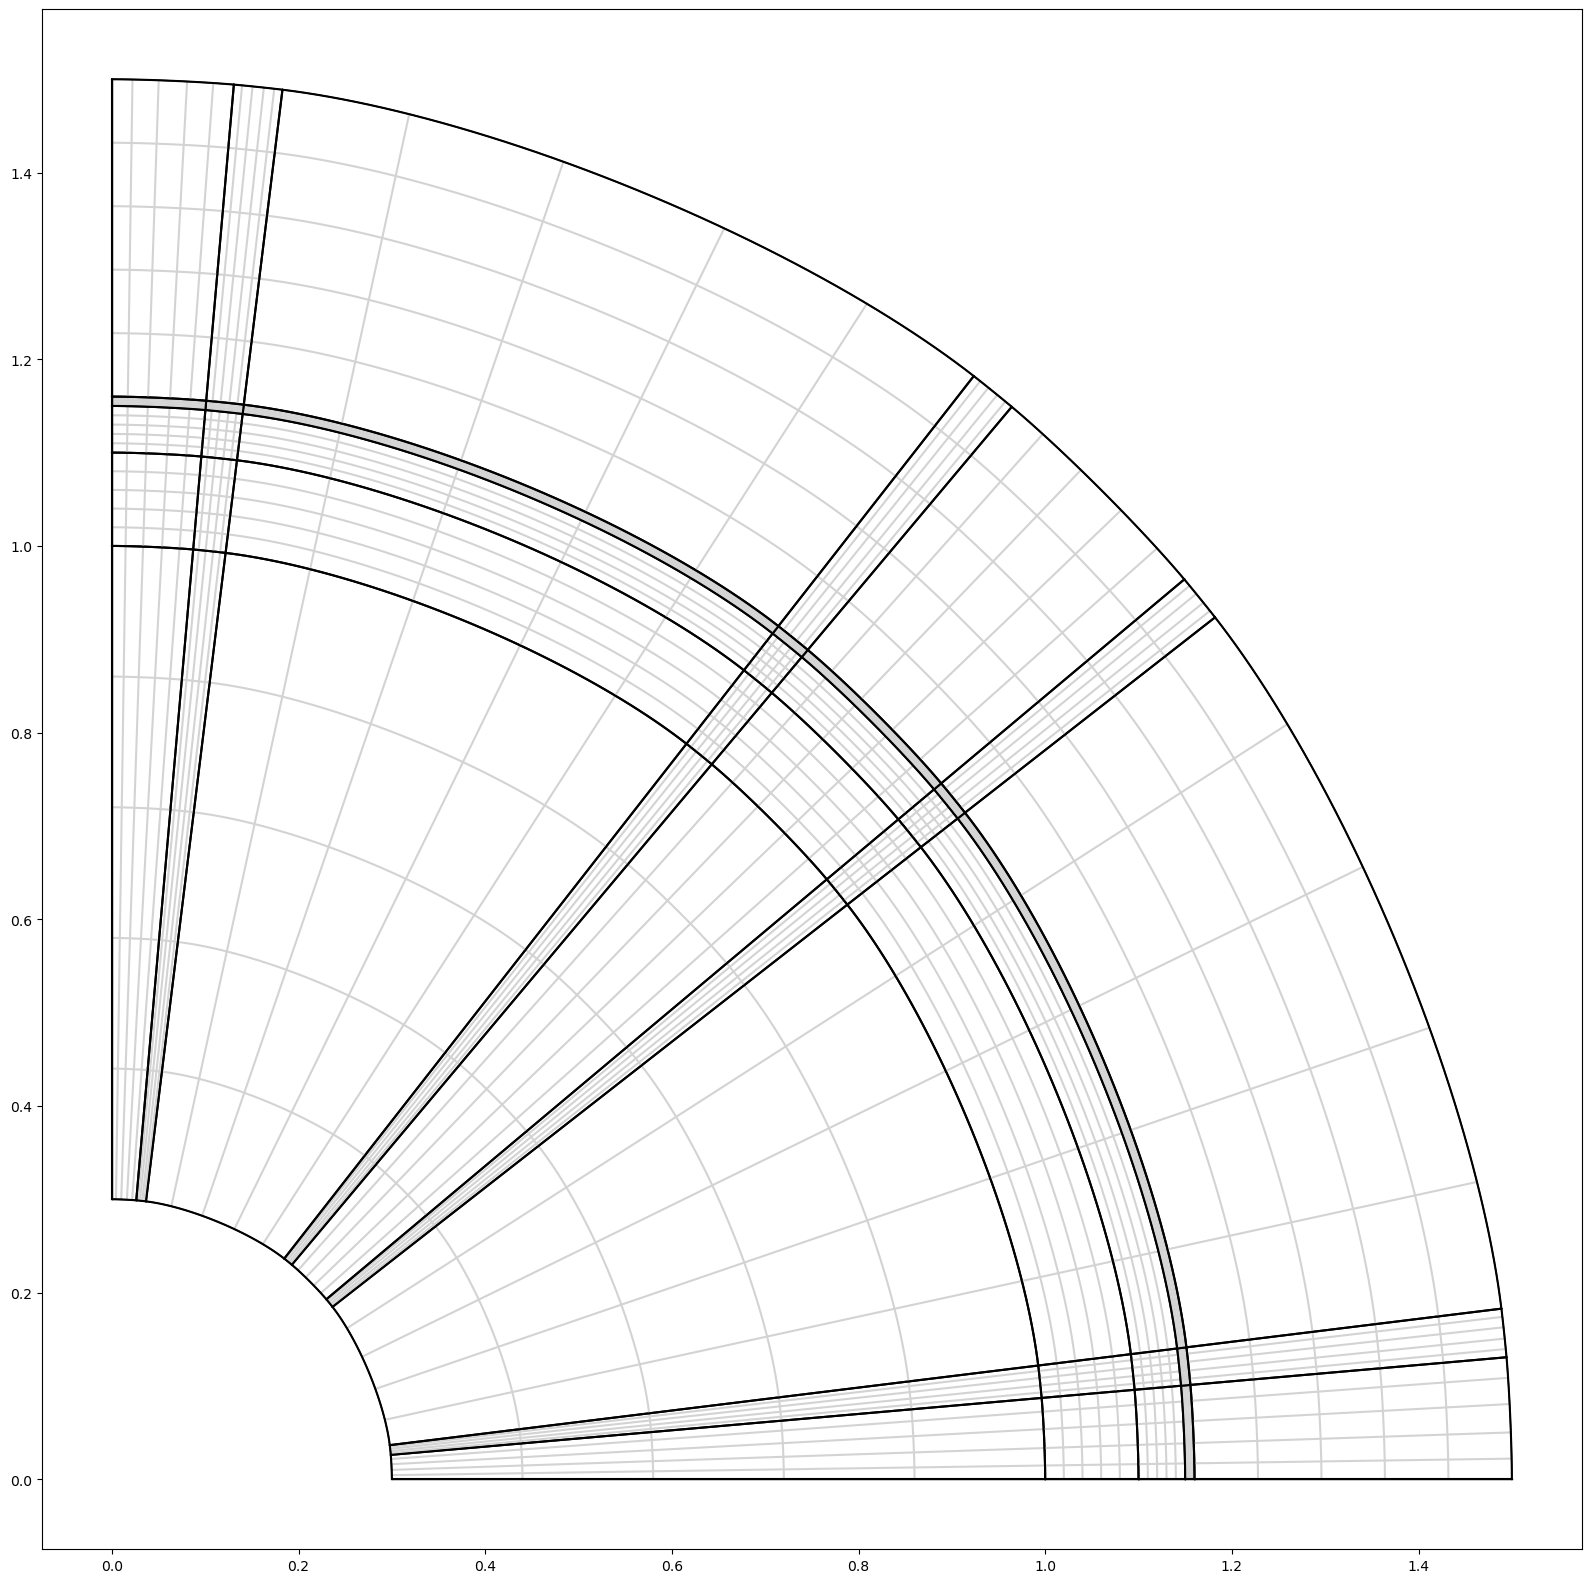

In [41]:
M.draw(figsize=(20,20),knots=True)
#plt.axis('off')
#MP.plot(uh, cmap='gnuplot2', axis='scaled')
#plt.axis('off')

In [19]:
M=topology.PatchMesh([(2*(bspline.make_knots(2,0.0,1.0,4),),geometry.unit_square())])
MP=assemble.Multipatch(M, automatch=True)

Basis setup took 0.0022804737091064453 seconds


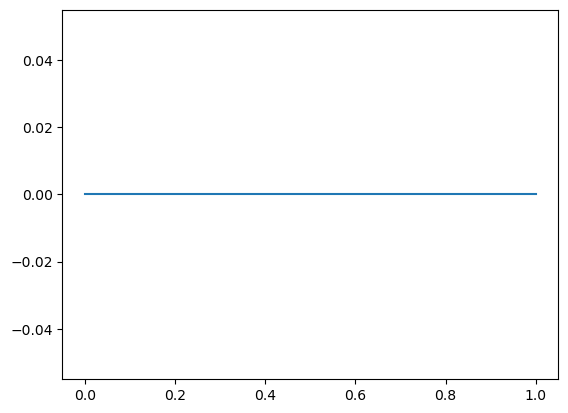

In [21]:
plt.plot([0.0,0.0])

In [3]:
u_ = MP.L2projection(lambda x,y: x**2+y**2)

AttributeError: 'Figure' object has no attribute 'get_array'

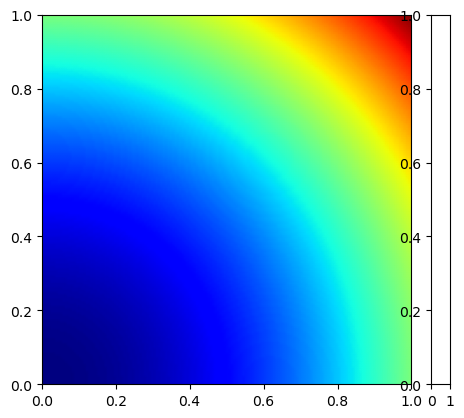

In [4]:
MP.plot(plt.figure(),u_)

In [5]:
fig=plt.figure()

<Figure size 640x480 with 0 Axes>